<a href="https://colab.research.google.com/github/datacentertugaskuliah-coder/PraktikumDS/blob/main/Proses_End_to_End_Data_Science_(Time_Series_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Jumlah NaT setelah parsing: 114
Jumlah baris bersih: 9357


,datetime,CO(GT),PT08.S1(CO),C6H6(GT),NO2(GT),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,11.9,113.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,9.4,92.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,9.0,114.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,9.2,122.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,6.5,116.0,11.2,59.6,0.7888


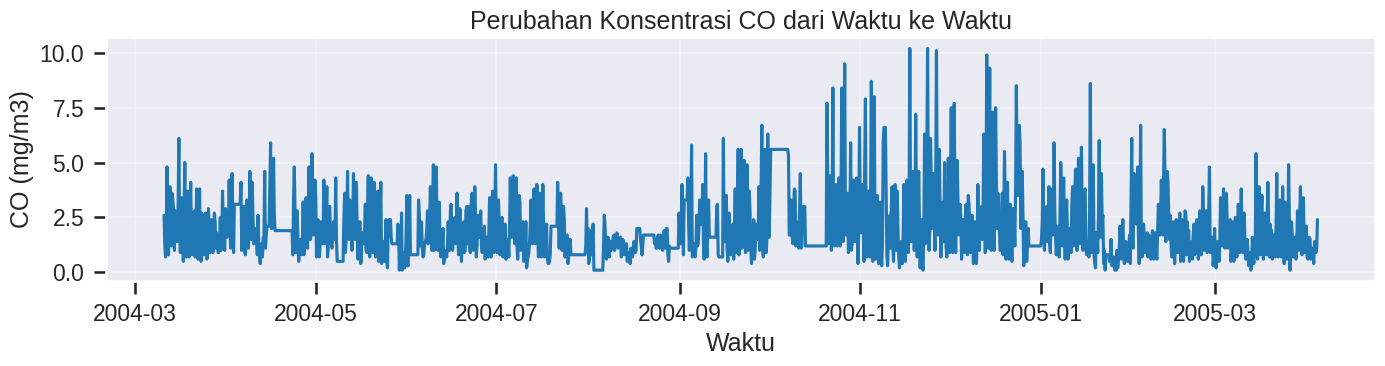

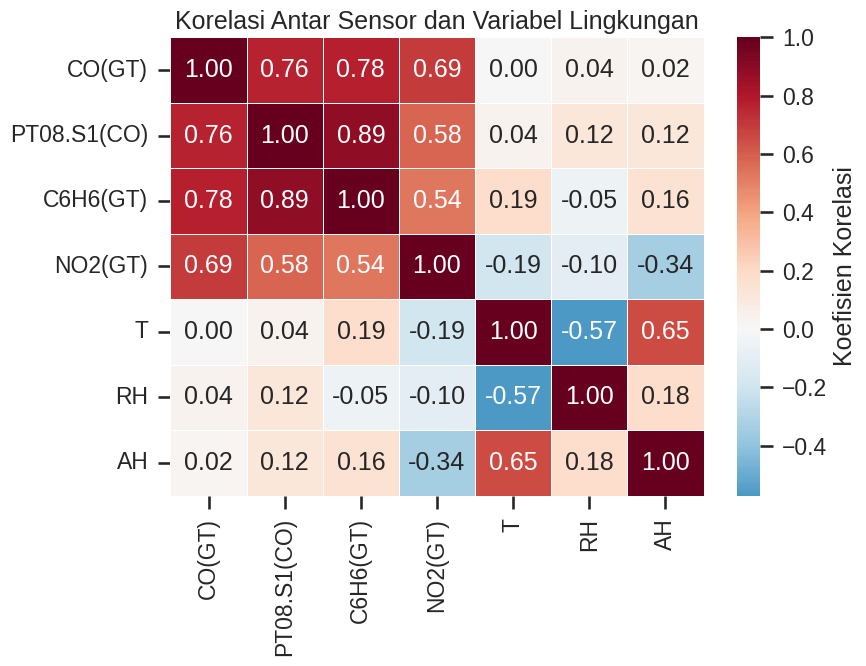

Baris setelah feature engineering: 9353


,datetime,CO(GT),PT08.S1(CO),C6H6(GT),NO2(GT),T,RH,AH,CO_lag_1,CO_lag_2,CO_lag_3,target_CO_next1h
0,2004-03-10 21:00:00,2.2,1376.0,9.2,122.0,11.0,60.0,0.7867,2.2,2.0,2.6,1.6
1,2004-03-10 22:00:00,1.6,1272.0,6.5,116.0,11.2,59.6,0.7888,2.2,2.2,2.0,1.2
2,2004-03-10 23:00:00,1.2,1197.0,4.7,96.0,11.2,59.2,0.7848,1.6,2.2,2.2,1.2
3,2004-03-11 00:00:00,1.2,1185.0,3.6,77.0,11.3,56.8,0.7603,1.2,1.6,2.2,1.0
4,2004-03-11 01:00:00,1.0,1136.0,3.3,76.0,10.7,60.0,0.7702,1.2,1.2,1.6,0.9


Train shape: (7482, 9)
Test shape : (1871, 9)
=== HASIL EVALUASI ===
Baseline Naive -> MAE: 0.491 | RMSE: 0.785
RandomForest  -> MAE: 0.659 | RMSE: 0.929


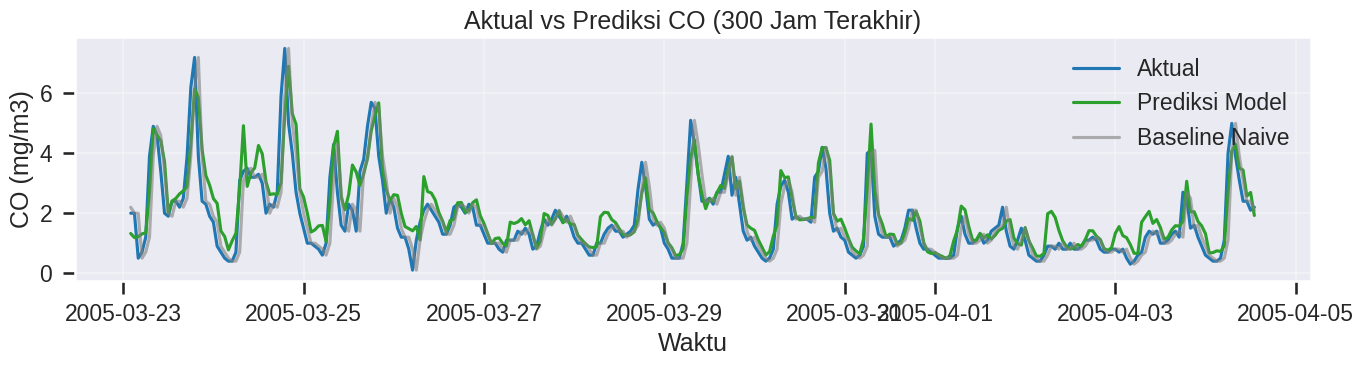

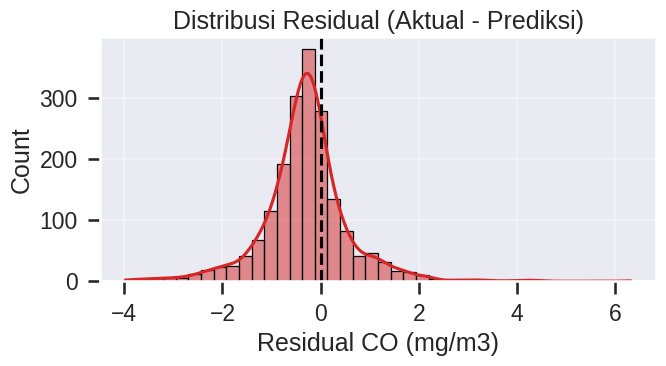

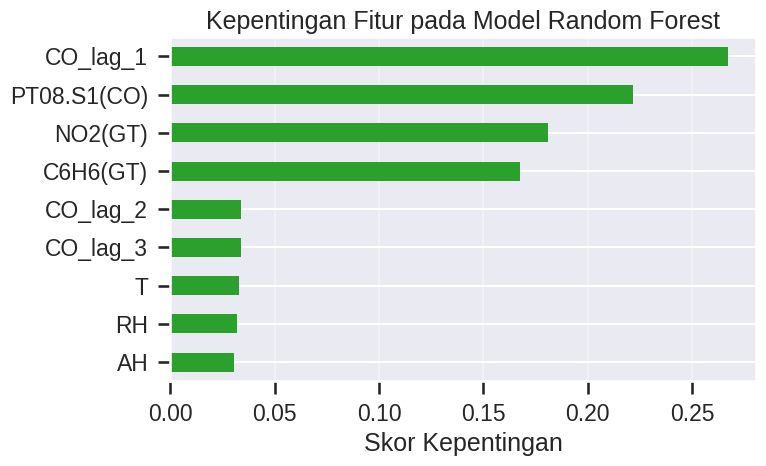

Contoh prediksi CO 1 jam ke depan: 1.9666666666666652


In [8]:
# ==========================================================
# Praktikum Data Science dan Machine Learning Berbasis Python dan UCI Repository
# Pembahasan : Proses End-to-End Data Science (Time Series Regression)
# Dataset    : Air Quality (UCI Machine Learning Repository)
# URL        : https://archive.ics.uci.edu/dataset/387/air+quality
# Lingkungan : Google Colab
# Versi      : FINAL TERGABUNG (Stabil, Bersih, Mudah Dibaca)
# Tujuan     : Prediksi konsentrasi CO satu jam ke depan
# ==========================================================


# ==========================================================
# 1) PERSIAPAN LINGKUNGAN
# ==========================================================
!pip -q install seaborn joblib requests

import io
import zipfile
import requests
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8")
sns.set_context("talk")


# ==========================================================
# 2) PEMAHAMAN BISNIS
# ==========================================================
# Tujuan:
# Memprediksi konsentrasi CO (mg/m3) pada waktu t+1 (1 jam ke depan)
#
# Nilai praktis:
# Mendukung sistem peringatan dini kualitas udara
#
# Prinsip:
# - Data time series -> split kronologis
# - Fitur hanya berasal dari waktu t atau sebelumnya
# - Baseline naive wajib sebagai pembanding


# ==========================================================
# 3) PENGUMPULAN DATA (ZIP MULTI-FILE -> CSV )
# ==========================================================
zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"

resp = requests.get(zip_url, timeout=60)
resp.raise_for_status()

z = zipfile.ZipFile(io.BytesIO(resp.content))
assert "AirQualityUCI.csv" in z.namelist(), f"CSV tidak ditemukan. Isi ZIP: {z.namelist()}"

with z.open("AirQualityUCI.csv") as f:
    df = pd.read_csv(f, sep=";", decimal=",")

# Hapus kolom kosong bawaan file
for col in ["Unnamed: 15", "Unnamed: 16"]:
    if col in df.columns:
        df = df.drop(columns=[col])

display(df.head())


# ==========================================================
# 4) PEMBERSIHAN DATA (TANPA WARNING, TANPA LEAKAGE)
# ==========================================================
# Sentinel -200 = pembacaan sensor tidak valid
df = df.replace(-200, np.nan)

# Parsing datetime eksplisit (tanpa warning)
df["datetime"] = pd.to_datetime(
    df["Date"].astype(str) + " " + df["Time"].astype(str),
    format="%d/%m/%Y %H.%M.%S",
    errors="coerce"
)

print("Jumlah NaT setelah parsing:", df["datetime"].isna().sum())

df = df.dropna(subset=["datetime"])
df = df.drop(columns=["Date", "Time"])
df = df.sort_values("datetime").reset_index(drop=True)

# Pilih kolom penting
df = df[[
    "datetime",
    "CO(GT)",
    "PT08.S1(CO)",
    "C6H6(GT)",
    "NO2(GT)",
    "T",
    "RH",
    "AH"
]]

# Forward fill kausal (hanya masa lalu)
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].ffill()

df = df.dropna(subset=["CO(GT)"])

print("Jumlah baris bersih:", len(df))
display(df.head())


# ==========================================================
# 5) EKSPLORASI DATA (EDA)
# ==========================================================

# ---- Time series CO (downsample visual)
df_plot = df.iloc[::6]

plt.figure(figsize=(14,4))
plt.plot(df_plot["datetime"], df_plot["CO(GT)"], color="tab:blue")
plt.title("Perubahan Konsentrasi CO dari Waktu ke Waktu")
plt.xlabel("Waktu")
plt.ylabel("CO (mg/m3)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Heatmap korelasi
corr_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(9,7))
sns.heatmap(
    corr_df.corr(),
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Koefisien Korelasi"}
)
plt.title("Korelasi Antar Sensor dan Variabel Lingkungan")
plt.tight_layout()
plt.show()


# ==========================================================
# 6) FEATURE ENGINEERING
# ==========================================================
df_feat = df.copy()

for lag in [1, 2, 3]:
    df_feat[f"CO_lag_{lag}"] = df_feat["CO(GT)"].shift(lag)

df_feat["target_CO_next1h"] = df_feat["CO(GT)"].shift(-1)

df_feat = df_feat.dropna().reset_index(drop=True)

min_rows_required = 200
print("Baris setelah feature engineering:", len(df_feat))
if len(df_feat) < min_rows_required:
    raise ValueError("Data tidak cukup untuk modeling.")

display(df_feat.head())


# ==========================================================
# 7) SPLIT DATA (TIME-BASED)
# ==========================================================
feature_cols = [
    "PT08.S1(CO)",
    "C6H6(GT)",
    "NO2(GT)",
    "T",
    "RH",
    "AH",
    "CO_lag_1",
    "CO_lag_2",
    "CO_lag_3"
]

split_idx = int(len(df_feat) * 0.8)

train_df = df_feat.iloc[:split_idx]
test_df  = df_feat.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df["target_CO_next1h"]

X_test  = test_df[feature_cols]
y_test  = test_df["target_CO_next1h"]

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


# ==========================================================
# 8) BASELINE NAIVE
# ==========================================================
y_pred_naive = test_df["CO(GT)"].values


# ==========================================================
# 9) PEMODELAN
# ==========================================================
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


# ==========================================================
# 10) EVALUASI (RMSE VERSION-AGNOSTIC)
# ==========================================================
y_pred = model.predict(X_test)

mae_model = mean_absolute_error(y_test, y_pred)
mse_model = mean_squared_error(y_test, y_pred)
rmse_model = float(np.sqrt(mse_model))

mae_naive = mean_absolute_error(y_test, y_pred_naive)
mse_naive = mean_squared_error(y_test, y_pred_naive)
rmse_naive = float(np.sqrt(mse_naive))

print("=== HASIL EVALUASI ===")
print(f"Baseline Naive -> MAE: {mae_naive:.3f} | RMSE: {rmse_naive:.3f}")
print(f"RandomForest  -> MAE: {mae_model:.3f} | RMSE: {rmse_model:.3f}")


# ---- Plot aktual vs prediksi (300 jam terakhir)
plot_len = 300

plt.figure(figsize=(14,4))
plt.plot(test_df["datetime"].iloc[-plot_len:], y_test.values[-plot_len:], label="Aktual", color="tab:blue")
plt.plot(test_df["datetime"].iloc[-plot_len:], y_pred[-plot_len:], label="Prediksi Model", color="tab:green")
plt.plot(test_df["datetime"].iloc[-plot_len:], y_pred_naive[-plot_len:], label="Baseline Naive", color="gray", alpha=0.6)
plt.legend()
plt.title("Aktual vs Prediksi CO (300 Jam Terakhir)")
plt.xlabel("Waktu")
plt.ylabel("CO (mg/m3)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Distribusi residual
residuals = y_test.values - y_pred

plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=40, kde=True, color="tab:red")
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribusi Residual (Aktual - Prediksi)")
plt.xlabel("Residual CO (mg/m3)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Feature importance
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values()

plt.figure(figsize=(8,5))
importances.plot(kind="barh", color="tab:green")
plt.title("Kepentingan Fitur pada Model Random Forest")
plt.xlabel("Skor Kepentingan")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


# ==========================================================
# 11) DEPLOYMENT
# ==========================================================
artifact = {
    "model": model,
    "feature_cols": feature_cols
}
joblib.dump(artifact, "air_quality_co_next1h_rf.joblib")

def predict_next_co_1h(sensor_row, co_history):
    if len(co_history) < 3:
        raise ValueError("Minimal 3 histori CO dibutuhkan")

    row = {
        "PT08.S1(CO)": sensor_row["PT08.S1(CO)"],
        "C6H6(GT)": sensor_row["C6H6(GT)"],
        "NO2(GT)": sensor_row["NO2(GT)"],
        "T": sensor_row["T"],
        "RH": sensor_row["RH"],
        "AH": sensor_row["AH"],
        "CO_lag_1": co_history[-1],
        "CO_lag_2": co_history[-2],
        "CO_lag_3": co_history[-3],
    }

    X_one = pd.DataFrame([row], columns=artifact["feature_cols"])
    return float(artifact["model"].predict(X_one)[0])

# Contoh uji deployment
last = df_feat.iloc[-1]
sensor_example = {
    "PT08.S1(CO)": last["PT08.S1(CO)"],
    "C6H6(GT)": last["C6H6(GT)"],
    "NO2(GT)": last["NO2(GT)"],
    "T": last["T"],
    "RH": last["RH"],
    "AH": last["AH"],
}
co_hist = df_feat["CO(GT)"].iloc[-3:].tolist()

print("Contoh prediksi CO 1 jam ke depan:", predict_next_co_1h(sensor_example, co_hist))
